# A Content Based Image Retrieval Pipeline
This version of the pipeline is designed to run for PCs with low specifications and for large datasets. Python generators are used to create batches of data and then each batch is written to disk and loaded when needed for processing

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.metrics.pairwise import euclidean_distances,cosine_distances
import collections
import os
import pickle
from tqdm import tqdm_notebook as tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import itertools

In [2]:
# tqdm is being used to make the progress bar - Run this once only
%%capture
tqdm().pandas()

UsageError: Line magic function `%%capture` not found.


In [33]:
def write_dict(dict_obj,path='dict'):
    with open(path,'wb') as handle:
                    pickle.dump(dict_obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def read_dict(path):
    obj = None
    with open(path, 'rb') as handle:
        obj = pickle.load(handle)
    return obj

## Import Dataset

In [3]:
def get_name(filename):
    i = filename.rfind('/')
    j = filename.rfind('.')
    return filename[i+1:j]

In [4]:
def get_image(filename,grayscale=False):
    if grayscale == True:
        return cv2.resize(cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2GRAY).astype('uint8'),(256,256))
    else:
        return cv2.resize(cv2.cvtColor(cv2.imread(filename),cv2.COLOR_BGR2RGB).astype('uint8'),(256,256))

In [5]:
def image_generator(image_paths, batch_size = 21):
    total_size = len(image_paths)
    indices = np.arange(0, total_size, batch_size)
    if total_size % batch_size != 0:
        indices = indices[:-1]
    for index in indices:
        batch_paths = image_paths[index:index+batch_size]
        image_batch = {get_name(image):get_image(image) for image in batch_paths}

        yield image_batch

In [6]:
def get_true_similar(all_files,query,return_images = False):
    base_name = ''.join([char for char in query if not char.isdigit()])
    ground_truth = [filepath for filepath in all_files if base_name in filepath]
    if return_images:
        return {get_name(image):get_image(image) for image in ground_truth}
    else:
        return [get_name(image) for image in ground_truth]

## Feature Extraction

### Generators for feature extraction
Here we create generators for all the descriptors we wish to use

In [7]:
# A function that helps determine whether a generator is empty or not
def getBatch(gen):
    try:
        batch = next(gen)
    except StopIteration:
        return None
    return batch

#### SIFT

In [8]:
def sift_gen(img_gen):
    sift = cv2.xfeatures2d.SIFT_create()
    img_batch = 1
    while img_batch:
        img_batch = getBatch(img_gen)
        if img_batch is not None:
            yield {filename:sift.detectAndCompute(img,None)[1] for (filename,img) in img_batch.items()}
        else:
            break
    yield None

#### SURF

In [9]:
def surf_gen(img_gen):
    surf = cv2.xfeatures2d.SURF_create(400)
    img_batch = 1
    while img_batch:
        img_batch = getBatch(img_gen)
        if img_batch is not None:
            yield {filename:surf.detectAndCompute(img,None)[1] for (filename,img) in img_batch.items()}
        else:
            break
    yield None

#### Histogram

In [10]:
def gray_histogram(image):
    img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return cv2.calcHist(img,[0],None,[256],[0, 256]).flatten()

In [11]:
def histogram_gen(img_gen):
    img_batch = 1
    while img_batch:
        img_batch = getBatch(img_gen)
        if img_batch is not None:
            yield {filename:gray_histogram(img) for (filename,img) in img_batch.items()}
        else:
            break
    yield None

#### Histogram of Oriented Gradients (HOG)

In [12]:
def compute_hog(image):
    hog = cv2.HOGDescriptor()
    return hog.compute(image).flatten()

In [13]:
def hog_gen(img_gen):
    img_batch = 1
    while img_batch:
        img_batch = getBatch(img_gen)
        if img_batch is not None:
            yield {filename:compute_hog(img) for (filename,img) in img_batch.items()}
        else:
            break
    yield None

#### Local Histogram

In [14]:
def split_image(image, factor):
    new_height = int(image.shape[1]/2)
    new_width = int(image.shape[0]/2)
    images = []
    images.append(image[0:new_height, 0:new_width])
    images.append(image[0:new_height, new_width:])
    images.append(image[new_height:, 0:new_width])
    images.append(image[new_height:, new_width:])
    if(factor <= 1):
        return images
    else:
        to_return = []
        for image in images:
            splits = split_image(image, factor-1)
            for split in splits:
                to_return.append(split)
        return to_return
            
def local_histogram(image, reduce_factor = 2):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    splits = split_image(image, reduce_factor)
    histograms = [cv2.calcHist(img,[0],None,[256],[0, 256]).flatten() for img in splits]
    flattened_hist = np.array([value for hist in histograms for value in hist])
    return flattened_hist

In [15]:
def local_hist_gen(img_gen):
    img_batch = 1
    while img_batch:
        img_batch = getBatch(img_gen)
        if img_batch is not None:
            yield {filename:local_histogram(img) for (filename,img) in img_batch.items()}
        else:
            break
    yield None

### Encoding Feature Vectors

#### Generating Vocabulary

In [16]:
def get_vocab(features_gen,batch_size=32,num_words=1028,path='vocabulary.pickle'):
    if os.path.exists(path):
        return read_dict(path)
    else:
        vocab = MiniBatchKMeans(n_clusters=num_words,random_state=0,batch_size=batch_size)
        features_dict = getBatch(features_gen)
        while features_dict != None:
            features = [desc for (path,desc) in features_dict.items() if desc is not None]
            features = list(itertools.chain.from_iterable(features))
            features = np.asarray(features)
            vocab.partial_fit(features)
            features_dict = getBatch(features_gen)
        write_dict(vocab,path)
        return vocab     

#### Bag of Visual Words

In [17]:
def min_r_items(distances, r):
    min_indices = []
    for i in range(r):
        minimum = float('inf')
        min_index = None
        for j in range(len(distances)):
            if(distances[j] < minimum):
                minimum = distances[j]
                min_index = j
        distances[min_index] = float('inf')
        min_indices.append(min_index)
    return min_indices

In [18]:
def bovw_gen(features_gen,vocabulary,assignment='hard'):
    all_words = []
    words = vocabulary.cluster_centers_
    features_to_use = np.zeros(words.shape[0])
    feature_size = words.shape[1]
    if assignment == 'hard':
        print('Creating Bag of Visual Word Representation')
        while True:
            batch = getBatch(features_gen)
            bovw_rep = {}
            if batch is not None:
                for name,image in batch.items():
                    assigned_word_indices = vocabulary.predict(image)
                    for index in assigned_word_indices:
                        features_to_use[index] = 1
                    c = 0
                    image_in_vocab = []
                    for word, check in zip(words, features_to_use):
                        if(check):
                            image_in_vocab.append(word)
                            c+=1
                        else:
                            image_in_vocab.append(np.zeros(feature_size))
                    image_in_vocab = np.array(image_in_vocab)
                    bovw_rep[name] = image_in_vocab
                #Yield a BoVW representation of current batch
                yield bovw_rep
            else:
                break
        yield None

#### Vector of Locally Aggregated Descriptors (VLAD)

In [19]:
#Computes a VLAD descriptor for a SINGLE image
def vlad(img_desc,vocabulary,alpha=0.5):
    assigned_words = vocabulary.predict(img_desc)
    words = vocabulary.cluster_centers_
    num_words = vocabulary.n_clusters
    num_desc,desc_size = img_desc.shape
    V = np.zeros((num_words,desc_size))
    
    for i,desc in enumerate(img_desc):
        index = assigned_words[i]
        V[index]+= desc - words[index]
    
    V = V.flatten()
    #Power normalize with alpha = 0.5
    V = np.sign(V) * np.power(np.abs(V),alpha)
    #L2 normalize
    V = V/np.sqrt(np.dot(V,V))
    return V

In [20]:
def vlad_gen(features_gen,vocabulary):
    while True:
        features_batch = getBatch(features_gen)
        if features_batch is not None:
            yield {filename:vlad(desc,vocabulary) for (filename,desc) in features_batch.items()}
        else:
            break
    yield None

### Feature Reduction

In [21]:
def pca_gen(feature_gen,num_comp=64):
    batch = 1
    pca = PCA(n_components=num_comp)
    while batch:
        batch = getBatch(feature_gen)
        if batch is not None:
            yield {filename:pca.fit_transform(desc) for (filename,desc) in batch.items()}
        else:
            break
    yield None

### Writing batches of descriptors to disk
We create batches of dictionaries with the format {Filename of Image: Descriptor} and create a index dictionary of the format {Batch Name: List of images in it}

In [22]:
def write_features_db(features_gen, path='db_batch',):
    if os.path.exists(path):
        return read_dict(path)
    else:
        batch = getBatch(features_gen)
        batch_index = 0
        db_index = {}
        name = ((path.split('/')[-1]).split('.'))[0]
        i = path.rfind('/')
        base_path = path[:i+1]
        while batch:
            batch_name = name + '_' + str(batch_index)
            files_in_batch = list(batch.keys())
            db_index[batch_name] = files_in_batch
            write_dict(batch,base_path+batch_name+'.pickle')
            batch = getBatch(features_gen)
            batch_index+=1
        db_index['BASE_PATH'] = base_path
        write_dict(db_index,path)
        return db_index  

## Similarity computation

In [23]:
def sort_by_value(dict_obj):
    return collections.OrderedDict(sorted(dict_obj.items(), key=lambda kv: kv[1]))

In [24]:
def compute_similarity(query_img_fv, features_db, dist='cosine'):
    all_similarity = None
    if dist == 'cosine':
        all_similarity = {filename:cosine_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    elif dist == 'euclidean':
        all_similarity = {filename:euclidean_distances(query_img_fv.reshape(1, -1),img_fv.reshape(1, -1))[0,0] for (filename,img_fv) in features_db.items()}
    return sort_by_value(all_similarity)

## Evaluation

### Get Results

In [25]:
#Read a query image from a batch stored in disk
def read_fv(query,index):
    base_path = index['BASE_PATH']
    for key in index:
        if query in index[key]:
            batch_db = read_dict(base_path+key+'.pickle')
            return batch_db[query]

#Read a query image from a feature generator in memory
def image_from_feature_db(features_db, query):
    for batch in features_db:
        if query in batch:
            return batch[query]

In [26]:
def get_similar(query,db_index,dist='cosine'):
    top_results = {}
    query_fv = read_fv(query,db_index)
    base_path = db_index['BASE_PATH']
    for key in db_index:
        if key != 'BASE_PATH':
            batch_db = read_dict(base_path+key+'.pickle')
            batch_results = compute_similarity(query_fv,batch_db,dist=dist)
            combined_results = {**top_results,**batch_results}
            top_results = sort_by_value(combined_results)
    return top_results

### Visualize Results

In [27]:
def get_file_path(name,all_files):
    for path in all_files:
        filename = path.split('/')[-1]
        if filename.split('.')[0] == name:
            return path
    return None

def showResults(results_dict,query_img,all_files):
    top_ten_similar = []
    i=0
    for k, v in results_dict.items():
        path = get_file_path(k,all_files)
        top_ten_similar.append(get_image(path))
        if(i < 10):
            i+=1
        else:
            break

    print(f"Retrieved images similar to image {query_img} are as follows")
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4), dpi=100)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(top_ten_similar[i], cmap='gray')
        ax.grid(False)
        ax.axis('off')

### Performance Metrics

#### Mean Average Precision (MAP)

In [28]:
def PatK(ground_truth, retrieved, k):
    true_positives = 0.0
    for i in range(k):
        if retrieved[i] in ground_truth:
            true_positives += 1
            if i == (k-1):
                precision = true_positives / float(k)
                return precision
        elif i == (k-1):
            return 0.0

def AP(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    retrieved_size = len(retrieved)
    
    total_precision = 0.0
    
    for i in range(1, retrieved_size):
        precision_at_k = PatK(ground_truth, retrieved, i)
        total_precision += precision_at_k
    return (total_precision/gt_size)
    
# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def MAP(query_list, all_files, db_index):
    total_AP = 0.0
    print("Computing MAP")
    for query in tqdm(query_list):
        image_gen = image_generator(all_files)
        ground_truth = get_true_similar(all_files, query)

        retrieved = get_similar(query,db_index)
        retrieved_list = list(retrieved.keys())
        
        average_precision = AP(ground_truth, retrieved_list)
        total_AP += average_precision
    return total_AP / float(len(query_list))

#### Average Normalised Mean Retrieval Rank (ANMRR)

In [29]:
def K(gt):
    return float(2*len(gt))

def MeanRank(ground_truth, retrieved):
    total_rank = 0.0
    gt_size = len(ground_truth)
    k = K(ground_truth)
    for image in ground_truth:
        position = retrieved.index(image)
        if(position > k):
            total_rank += 1.25*k
        else:
            total_rank += float(position)
    
    return total_rank/gt_size
        
def NMRR(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    mrr = MeanRank(ground_truth, retrieved) - 0.5*(1 + gt_size)
    if(mrr < 0):
        mrr = 0
    nmrr = mrr / (1.25*K(ground_truth) - 0.5*(1 + gt_size))
    
    return nmrr

# All helper functions directly take lists, so they need to be converted from
# dictionaries to lists that only contain the names of the images
def ANMRR(query_list, all_files, db_index):
    total_nmrr = 0.0
    print("Computing ANMMR")
    for query in tqdm(query_list):
        image_gen = image_generator(all_files)
        ground_truth = get_true_similar(all_files, query)
        
        retrieved = get_similar(query,db_index)
        retrieved_list = list(retrieved.keys())
        
        nmrr = NMRR(ground_truth, retrieved_list)
        total_nmrr += nmrr
    return total_nmrr/float(len(query_list))

## Final Pipeline

In [30]:
file_directory = "Smaller_Dataset/**/*.tif"
features_directory = 'Features/'

#These take in an image generator
descriptors = {
    'sift' : sift_gen,
    'surf' : surf_gen,
    'histogram' : histogram_gen,
    'local_hist' : local_hist_gen,
    'hog' : hog_gen,
}

#These take in a feature generator
encoding = {
    'vlad' : vlad_gen,
    'bovw' : bovw_gen,
}

#Paths used to store data
paths = {
    'vocabulary' : {
        'sift' : features_directory+'SIFT/vocabulary.pickle',
        'surf' : features_directory+'SURF/vocabulary.pickle',
        'histogram' : features_directory+'Histogram/vocabulary.pickle',
        'local_hist' : features_directory+'Local Histogram/vocabulary.pickle',
        'hog' : features_directory+'HOG/vocabulary.pickle',
    },
    'features' : {
        'sift' : features_directory+'SIFT/features.pickle',
        'surf' : features_directory+'SURF/features.pickle',
        'histogram' : features_directory+'Histogram/features.pickle',
        'local_hist' : features_directory+'Local Histogram/features.pickle',
        'hog' : features_directory+'HOG/features.pickle',
        'SIFTxBoVW' : features_directory+'SIFT/BoVW/features.pickle',
        'SIFTxVLAD' : features_directory+'SIFT/VLAD/features.pickle',
        'SURFxBoVW' : features_directory+'SURF/BoVW/features.pickle',
        'SURFxVLAD' : features_directory+'SURF/VLAD/features.pickle',
    }
}

In [62]:
#Set up variables
query_list = ['buildings02', 'beach01', 'river03','agricultural00']
query = query_list[2]
batch_size = 21

all_files = glob.glob(file_directory)

In [57]:
# Generate Vocabulary
image_gen = image_generator(all_files,batch_size=batch_size)
features_gen = descriptors['surf'](image_gen)
path = paths['vocabulary']['surf']
vocabulary = get_vocab(features_gen,batch_size=batch_size,path=path,num_words=1028)

In [49]:
#Generate Feature Descriptors
image_gen = image_generator(all_files,batch_size=batch_size)
features_gen = descriptors['surf'](image_gen)
encoded_features_gen = encoding['bovw'](features_gen,vocabulary)
path = paths['features']['SURFxBoVW']
features_index = write_features_db(encoded_features_gen,path=path)

In [63]:
#Get Results
query_results = get_similar(query,features_index)

In [58]:
scores = {
    'map' : MAP(query_list,all_files,features_index),
    'anmrr' : ANMRR(query_list,all_files,features_index)
}

Computing MAP



Computing ANMMR


In [60]:
scores

{'map': 0.6163246929946209, 'anmrr': 0.3038461538461538}

Retrieved images similar to image river03 are as follows


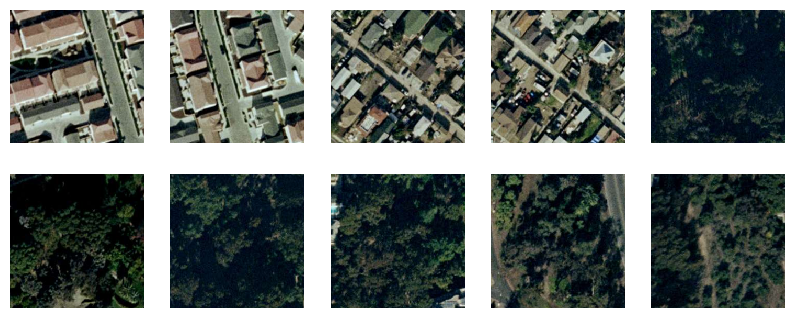

In [64]:
showResults(query_results,query,all_files)